In [1]:
import os
import re
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)

In [3]:
def data_to_dense(voxel_data, voxel_map_shape=(128, 128, 128), value=1.0):
    dense_objs_voxel_data = []
    
    for obj_voxel_coordinates in voxel_data:
        voxel_map = np.zeros(voxel_map_shape, dtype=np.float32)
        voxel_map[tuple(obj_voxel_coordinates.T)] = value
        dense_objs_voxel_data.append(voxel_map)
        
    return dense_objs_voxel_data

In [4]:
def rotate_obj_voxel_data(voxel_coordinates, rotation_angle, voxel_map_shape=(128, 128, 128)):    
    theta = np.pi * (rotation_angle / 180)
    
    rotation_matrix = np.array([[np.cos(theta), 0, np.sin(theta)],
                                [0, 1, 0],
                                [-np.sin(theta), 0, np.cos(theta)]])
    
    center = np.array(voxel_map_shape) / 2
    translated_coords = voxel_coordinates - center
    
    rotated_coords = np.dot(translated_coords, rotation_matrix.T)
    rotated_coords += center
    
    rotated_coords = np.round(rotated_coords).astype(int)
    valid_indices = np.all((rotated_coords >= 0) & (rotated_coords < np.array(voxel_map_shape)), axis=1)
    
    rotated_coords = rotated_coords[valid_indices]
    
    return rotated_coords

In [5]:
class DataGenerator:
    def __init__(self, dataset_dir_pth, each_chair_parts_count_pth, objs_count=None, voxel_map_shape=(128, 128, 128)):
        self.dataset_dir_pth = dataset_dir_pth
        
        self.each_chair_parts_count = np.load(each_chair_parts_count_pth)[:objs_count]
        self.num_objts = objs_count
        
        self.data_names = np.array(sorted_alphanumeric(os.listdir(self.dataset_dir_pth)), dtype=str)[:self._get_total_parts_size()]
        self.num_parts = len(self.data_names)
        
        self.curr_index = 0
        self.indexes = np.arange(self.num_parts)
        
        self.voxel_map_shape = voxel_map_shape
        self.voxel_data_sparse = self._load_voxel_data()
    
    def _get_total_parts_size(self):
        count = 0
        
        if self.num_objts == None:
            return None
        
        for i in range(self.num_objts):
            count += self.each_chair_parts_count[i]
        
        return count
    
    def _load_voxel_data(self):
        voxel_data_sparse = []
        for data_name in tqdm(self.data_names, desc="Loading Voxel Data"):
            data_pth = os.path.join(self.dataset_dir_pth, data_name)
            voxel_data_sparse.append(np.load(data_pth))
        return voxel_data_sparse

    def __iter__(self):
        return self

    def __next__(self):
        if self.curr_index >= len(self.indexes):
            self.curr_index = 0
            raise StopIteration
        
        index = self.curr_index
        
        sparse_data = self._load_batched_sparse_data([index])
        
        self.curr_index += 1
        
        return index, sparse_data
    
    def _load_batched_sparse_data(self, indexes):
        voxel_data_sparse = []
        
        if self.voxel_data_sparse is not None:
            for i in indexes:
                voxel_data_sparse.append(self.voxel_data_sparse[i])
                
            return voxel_data_sparse
        else:
            indexed_data_names = self.data_names[indexes]

            for data_name in indexed_data_names:
                data_pth = os.path.join(self.dataset_dir_pth, data_name)

                voxel_data_sparse.append(np.load(data_pth))  # attention ! bottleneck here

            return voxel_data_sparse
    
    def reset_index(self):
        self.curr_index = 0

In [6]:
class GeometryNetwork:
    def __init__(self, hparam):
        self.latent_code_dim = hparam['model_latent_code_dim']

        self.fc_channels = hparam['model_fc_channels']

        self.conv_size = hparam['model_conv_size']

        self.num_latent_codes_parts = hparam['model_num_latent_codes_parts']

        self.learning_rate_network = hparam['model_learning_rate_network']
        self.learning_rate_codes = hparam['model_learning_rate_codes']

        self.model_voxel_map_shape = hparam['model_voxel_map_shape']

        self.checkpoint_dir = hparam['model_checkpoint_dir']

        self._init_model()
        self._init_optimizer()
        self._init_losser()
        self._init_checkpoint()

    def _init_model(self):
        self.part_generator = self._get_part_generator()

        self.latest_epoch = tf.Variable(0, trainable=False, dtype=tf.int64)

        init_latent_code_parts = tf.random.normal((self.num_latent_codes_parts, self.latent_code_dim))
        self.latent_code_vars_parts = tf.Variable(init_latent_code_parts, trainable=True)

        self.part_generator_trainable_variables = self.part_generator.trainable_variables

    def _get_part_generator(self):

        with tf.name_scope('Network/'):

            latent_code = tf.keras.layers.Input(shape=(self.latent_code_dim,))

            with tf.name_scope('FC_layers'):

                fc0 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(latent_code)

                fc1 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(fc0)

                fc2 = tf.keras.layers.Dense(self.fc_channels, activation='relu')(fc1)

                fc2_as_volume = tf.keras.layers.Reshape((1, 1, 1, self.fc_channels))(fc2)

            with tf.name_scope('GLO_VoxelDecoder'):

                decoder_1 = self._conv_t_block_3d(fc2_as_volume, num_filters=32, size=self.conv_size, strides=2)

                decoder_2 = self._conv_t_block_3d(decoder_1, num_filters=32, size=self.conv_size, strides=2)

                decoder_3 = self._conv_t_block_3d(decoder_2, num_filters=32, size=self.conv_size, strides=2)

                decoder_4 = self._conv_t_block_3d(decoder_3, num_filters=16, size=self.conv_size, strides=2)

                decoder_5 = self._conv_t_block_3d(decoder_4, num_filters=8, size=self.conv_size, strides=2)

                decoder_6 = self._conv_t_block_3d(decoder_5, num_filters=4, size=self.conv_size, strides=2)

                volume_out = self._conv_t_block_3d(decoder_6, num_filters=1, size=self.conv_size, strides=2, output_mode=True)

        return tf.keras.Model(inputs=[latent_code], outputs=[volume_out])

    def _conv_t_block_3d(self, tensor, num_filters, size, strides, alpha_lrelu=0.2, output_mode=False):
        conv_3D_transpose = tf.keras.layers.Conv3DTranspose(
            filters=num_filters,
            kernel_size=size,
            strides=strides,
            padding='same',
            kernel_initializer=tf.keras.initializers.glorot_normal(),
            use_bias=False
        )

        tensor = conv_3D_transpose(tensor)

        if output_mode:
            return tensor

        tensor = tf.keras.layers.BatchNormalization()(tensor)

        tensor = tf.keras.layers.LeakyReLU(alpha=alpha_lrelu)(tensor)

        return tensor

    def _init_optimizer(self):
        self.optimizer_part_generator = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_network)
        self.optimizer_latent_for_parts = tf.keras.optimizers.Adam(learning_rate=self.learning_rate_codes)

    def _init_losser(self):
        self.losser_bce = tf.keras.losses.BinaryCrossentropy()

    def _init_checkpoint(self):
        self.checkpoint = tf.train.Checkpoint(
            part_generator=self.part_generator,
            latent_code_vars_parts=self.latent_code_vars_parts,
            optimizer_part_generator=self.optimizer_part_generator,
            optimizer_latent_for_parts=self.optimizer_latent_for_parts,
            epoch=self.latest_epoch
        )

        self.manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                  directory=self.checkpoint_dir,
                                                  max_to_keep=1)

        self._load_checkpoint()

    def _load_checkpoint(self):
        latest_checkpoint = self.manager.latest_checkpoint

        if latest_checkpoint is not None:
            print('Checkpoint {} restored'.format(latest_checkpoint))
        else:
            print('No checkpoint was restored.')

        self.checkpoint.restore(latest_checkpoint).expect_partial()

    @tf.function
    def train_step_parts(self, latent_code_vars, true_voxels):
        with tf.GradientTape() as tape:
            pred_logits_voxels = self.part_generator(latent_code_vars)

            pred_voxels = tf.sigmoid(pred_logits_voxels)

            loss = self.losser_bce(true_voxels, pred_voxels)

        network_vars = self.part_generator_trainable_variables
        gradients = tape.gradient(loss, network_vars + [latent_code_vars])
                
        self.optimizer_part_generator.apply_gradients(zip(gradients[:len(network_vars)], network_vars))
        self.optimizer_latent_for_parts.apply_gradients(zip(gradients[len(network_vars):], [latent_code_vars]))

        return loss

    @tf.function
    def train_step_objts(self, latent_code_vars, true_voxels_objt):
        with tf.GradientTape() as tape:
            pred_logits_voxels = self.part_generator(latent_code_vars)
            pred_voxels = tf.sigmoid(pred_logits_voxels)
                                    
            pred_voxels_objt = tf.math.reduce_sum(pred_voxels, axis=0)
                                                
            loss = self.losser_bce(true_voxels_objt, pred_voxels_objt)
        
        gradients = tape.gradient(loss, [latent_code_vars])
                
        self.optimizer_latent_for_parts.apply_gradients(zip(gradients, [latent_code_vars]))

        return pred_voxels, loss

    def update_latent_code_vars_parts(self, latent_code_vars):
        self.latent_code_vars_parts.assign(latent_code_vars)

    def save_models(self, curr_epoch):
        self.latest_epoch.assign(curr_epoch)
        self.manager.save()

In [7]:
EACH_CHAIR_PARTS_COUNT_PTH = ".\\dataset\\each_chair_parts_count.npy"
DATASET_DIR_PTH = ".\\dataset\\chair_voxel_data"

LOAD_OBJS_COUNT = 10
VOXEL_MAP_SHAPE = (128, 128, 128)

TRAINING_EPOCH_FOR_PARTS = 3000

In [8]:
data_generator = DataGenerator(dataset_dir_pth=DATASET_DIR_PTH, each_chair_parts_count_pth=EACH_CHAIR_PARTS_COUNT_PTH, objs_count=LOAD_OBJS_COUNT)

Loading Voxel Data: 100%|██████████| 159/159 [00:00<00:00, 435.85it/s]


In [9]:
model_hparam = {
    'model_latent_code_dim': 256,
    'model_fc_channels': 512,
    'model_conv_size': 4,
    'model_num_latent_codes_parts': data_generator.num_parts,
    'model_learning_rate_network': 5e-4,
    'model_learning_rate_codes': 1e-3,
    'model_voxel_map_shape': VOXEL_MAP_SHAPE,
    'model_checkpoint_dir': './ckpt'
}

geom_network = GeometryNetwork(model_hparam)

No checkpoint was restored.


In [10]:
latest_epoch = geom_network.latest_epoch.numpy()

pbar = tqdm(range(latest_epoch+1, latest_epoch+TRAINING_EPOCH_FOR_PARTS+1), desc="Training on Parts")

data_generator.reset_index()

for epoch in pbar:
    total_loss = []
    
    latent_code_vars_parts = geom_network.latent_code_vars_parts.numpy()
    
    for voxel_index, true_voxels in data_generator:
        true_voxels = data_to_dense(true_voxels)
                        
        latent_code_vars = tf.Variable([latent_code_vars_parts[voxel_index]], trainable=True)
        
        true_voxels = np.expand_dims(true_voxels, axis=-1)
                
        loss = geom_network.train_step_parts(latent_code_vars, true_voxels).numpy()
        
        latent_code_vars_parts[voxel_index] = latent_code_vars.numpy()
        
        total_loss.append(loss)
                
    pbar.set_postfix({"Avg Loss": '{:.9f}'.format(sum(total_loss) / len(total_loss))})
    
    geom_network.update_latent_code_vars_parts(latent_code_vars_parts)

geom_network.save_models(epoch)

Training on Parts: 100%|██████████| 3000/3000 [1:44:33<00:00,  2.09s/it, Avg Loss=0.000014110]  


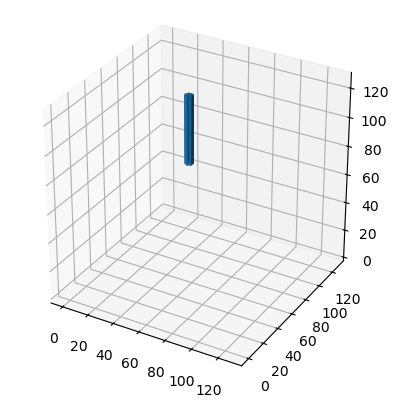

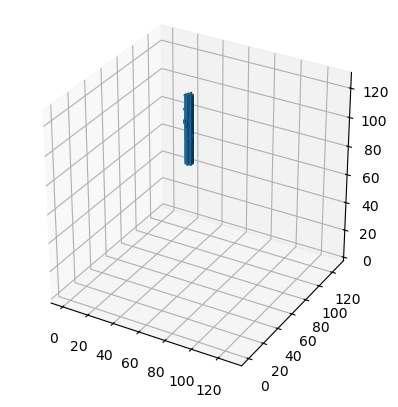

In [11]:
test_target_part = random.randint(0, data_generator.num_parts-1)

test_target_part = 0

true_voxels_coords = np.load(os.path.join(DATASET_DIR_PTH, str(test_target_part)+'.npy'))

true_voxel_rotated_coordinates = rotate_obj_voxel_data(true_voxels_coords, rotation_angle=180)
true_voxel_rotated = data_to_dense([true_voxel_rotated_coordinates])[0]

true_voxel_rotated_plot = np.moveaxis(true_voxel_rotated, 1, -1)

ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.voxels(true_voxel_rotated_plot)

plt.show()

latent_codes = tf.expand_dims(geom_network.latent_code_vars_parts[test_target_part], axis=0)

pred_logits_voxels = geom_network.part_generator(latent_codes)
pred_voxels = tf.sigmoid(pred_logits_voxels)
pred_voxels = tf.cast(tf.math.greater_equal(pred_voxels, 0.3), tf.float32).numpy()
pred_voxels = pred_voxels[0, :, :, :].reshape((pred_voxels.shape[1:4]))
pred_voxel_coordinates = np.where(pred_voxels == True)

x, y, z = pred_voxel_coordinates
pred_voxel_coordinates = np.expand_dims(x, axis=0).T
pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(y, axis=0).T), axis=1)
pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(z, axis=0).T), axis=1)

pred_voxel_rotated_coordinates = rotate_obj_voxel_data(pred_voxel_coordinates, rotation_angle=180)
pred_voxel_rotated = data_to_dense([pred_voxel_rotated_coordinates])[0]

pred_voxel_rotated_plot = np.moveaxis(pred_voxel_rotated, 1, -1)

ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.voxels(pred_voxel_rotated_plot)

plt.show()

In [ ]:
def save_plot(epoch, pred_voxels, palette):
    pred_voxels = tf.cast(tf.math.greater_equal(pred_voxels, 0.3), tf.float32).numpy()
    pred_voxels = pred_voxels.reshape((pred_voxels.shape[:4]))

    voxels = np.zeros(shape=VOXEL_MAP_SHAPE, dtype=np.int32)
    colors = np.zeros(shape=(*VOXEL_MAP_SHAPE, 3), dtype=np.float32)
    
    for i, part in enumerate(pred_voxels):
        pred_voxel_coordinates = np.where(part == True)
        
        x, y, z = pred_voxel_coordinates
        pred_voxel_coordinates = np.expand_dims(x, axis=0).T
        pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(y, axis=0).T), axis=1)
        pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(z, axis=0).T), axis=1)
        
        for coordinates in rotate_obj_voxel_data(pred_voxel_coordinates, rotation_angle=180):
            x, y, z = coordinates
            voxels[x, y, z] = 1
            colors[x, y, z] = palette[i]

    voxels = np.moveaxis(voxels, 1, -1)
    colors = np.moveaxis(colors, 1, -2)

    ax = plt.figure().add_subplot(projection='3d')
    ax.set_aspect('equal')
    ax.voxels(voxels, facecolors=colors)

    plt.savefig('./gif_imgs/{}_pred_parts'.format(str(epoch)) + '.png', dpi=300)
    
    plt.close()

In [12]:
TRAINING_EPOCH_FOR_OBJTS = 1500

USER_DEFINE_PARTS_NUM = 30

In [14]:
latent_code_vars = tf.Variable(tf.random.normal((USER_DEFINE_PARTS_NUM, geom_network.latent_code_dim)), trainable=True)

pbar = tqdm(range(1, TRAINING_EPOCH_FOR_OBJTS+1), desc="Training on Objects")

data_generator.reset_index()

palette = [np.array([random.random() for _ in range(3)], dtype=np.float32) for __ in range(USER_DEFINE_PARTS_NUM)]

target_object = 0

for epoch in pbar:
    total_loss = []
    
    start_count = 0
    for i in range(target_object):
        start_count += data_generator.each_chair_parts_count[i]
        
    range_count = start_count + data_generator.each_chair_parts_count[target_object]
                                            
    true_voxels = np.zeros(shape=(VOXEL_MAP_SHAPE), dtype=np.float32)
    
    for voxel_index, sparse_data in data_generator: # finding parts is slow here, not a good idea, but works.
        if voxel_index >= start_count:
            for x, y, z in sparse_data[0]:
                true_voxels[x, y, z] = 1
            
        if voxel_index == range_count-1:
            data_generator.reset_index()
            break
                                            
    true_voxels = tf.convert_to_tensor(np.expand_dims(true_voxels, axis=-1), dtype=tf.float32)
                                            
    pred_voxels, loss = geom_network.train_step_objts(latent_code_vars, true_voxels)
    
    # if epoch % 10 == 0:
    #     save_plot(epoch, pred_voxels, palette)
                    
    total_loss.append(loss.numpy())
        
    pbar.set_postfix({"Avg Loss": '{:.9f}'.format(sum(total_loss) / len(total_loss))})

Training on Objects:   0%|          | 0/1500 [00:00<?, ?it/s]

Training on Objects: 100%|██████████| 1500/1500 [04:06<00:00,  6.09it/s, Avg Loss=0.003128744]


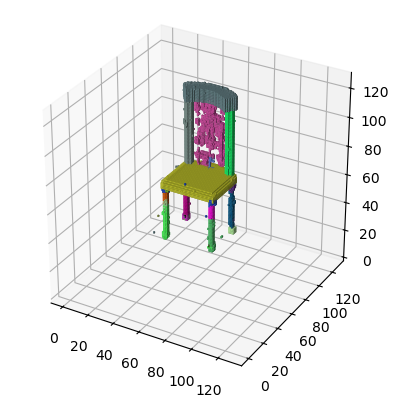

In [15]:
latent_codes = latent_code_vars.numpy()

pred_logits_voxels = geom_network.part_generator(latent_codes)
pred_voxels = tf.sigmoid(pred_logits_voxels)
pred_voxels = tf.cast(tf.math.greater_equal(pred_voxels, 0.3), tf.float32).numpy()
pred_voxels = pred_voxels.reshape((pred_voxels.shape[:4]))

voxels = np.zeros(shape=VOXEL_MAP_SHAPE, dtype=np.int32)
colors = np.zeros(shape=(*VOXEL_MAP_SHAPE, 3), dtype=np.float32)

for part in pred_voxels:
    pred_voxel_coordinates = np.where(part == True)
    
    x, y, z = pred_voxel_coordinates
    pred_voxel_coordinates = np.expand_dims(x, axis=0).T
    pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(y, axis=0).T), axis=1)
    pred_voxel_coordinates = np.concatenate((pred_voxel_coordinates, np.expand_dims(z, axis=0).T), axis=1)
    
    color = np.array([random.random() for _ in range(3)], dtype=np.float32)
    
    for coordinates in rotate_obj_voxel_data(pred_voxel_coordinates, rotation_angle=180):
        x, y, z = coordinates
        voxels[x, y, z] = 1
        colors[x, y, z] = color

voxels = np.moveaxis(voxels, 1, -1)
colors = np.moveaxis(colors, 1, -2)

ax = plt.figure().add_subplot(projection='3d')
ax.set_aspect('equal')
ax.voxels(voxels, facecolors=colors)

plt.show()

# plt.savefig('./{}_pred_parts'.format(str(0)) + '.png', dpi=300)

In [6]:
import imageio.v2 as imageio

img_list = sorted_alphanumeric(os.listdir('C:\\Users\\Matt\\Downloads\\Voxgen\\gif_imgs'))

gif_name = './voxgen_part.gif'

frames = []
for image_name in img_list:
    frames.append(imageio.imread(os.path.join('./gif_imgs', image_name)))
imageio.mimsave(gif_name, frames, 'GIF', duration=1, loop=0)